# Multi-Modal Surgery Pipeline with TOTALVI

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning) 

In [2]:
import scanpy as sc
import anndata
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np
import scvi as scv
import pandas as pd
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0
/root/anaconda3/envs/multigrate/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
rna = []
adt = []
for i in range(1,9):
    adt.append(sc.AnnData(pd.read_csv('./data/processed/wnn_p%d_cellmask/subset_0/mat/adt.csv'%i, index_col=0).values))
    rna.append(sc.AnnData(pd.read_csv('./data/processed/wnn_p%d_cellmask/subset_0/mat/rna.csv'%i, index_col=0).values))

In [5]:
for i in range(8):
    rna[i].obs[['batch']] = i
    adt[i].obs[['batch']] = i

In [6]:
rna = sc.concat(rna)
adt = sc.concat(adt)

In [ ]:
# rna = sc.read_h5ad('./data/raw/rna+adt/wnn/rna_new.h5ad')
# adt = sc.read_h5ad('./data/raw/rna+adt/wnn/adt_new.h5ad')
# rna

In [7]:
rna.obsm["protein_expression"] = pd.DataFrame(columns=adt.var_names, index=adt.obs_names, data = adt.X)

In [8]:
rna.obs['batch'] = rna.obs['batch'].astype('category')

In [9]:
sca.models.TOTALVI.setup_anndata(
    rna,
    batch_key="batch",
    protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                                       


In [36]:
adata_ref = rna[rna.obs['batch']==0].copy()
sca.models.TOTALVI.setup_anndata(
    adata_ref,
    batch_key="batch",
    protein_expression_obsm_key="protein_expression"
)
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
)
vae_ref = sca.models.TOTALVI(  
    adata_ref, 
    n_latent=32,
    **arches_params
)
vae_ref.train()

adata_ref.obsm["X_totalVI"] = vae_ref.get_latent_representation()
# sc.pp.neighbors(adata_ref, use_rep="X_totalVI")
# sc.tl.umap(adata_ref, min_dist=0.4)

# sc.pl.umap(
#     adata_ref,
#     color=["batch","l1"],
#     frameon=False,
#     ncols=1,
#     title="Reference"
# )

INFO     Using column names from columns of adata.obsm['protein_expression']                                       
INFO     Computing empirical prior initialization for protein background.                                          


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Epoch 400/400: 100%|██████████| 400/400 [04:08<00:00,  1.56it/s, loss=2.31e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:08<00:00,  1.61it/s, loss=2.31e+03, v_num=1]


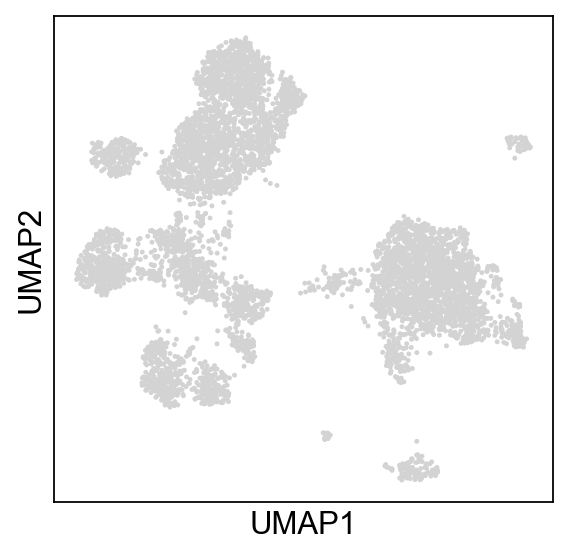

In [37]:
sc.pp.neighbors(adata_ref,use_rep="X_totalVI")
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref)

In [38]:
import os
if not os.path.exists('./result/wnn_cellmask/totalvi+scarches/train_0'):
    os.makedirs('./result/wnn_cellmask/totalvi+scarches/train_0')


dir_path = './result/wnn_cellmask/totalvi+scarches/train_0'

vae_ref.save(dir_path, overwrite=True)

In [41]:
os.makedirs('./result/wnn_cellmask/totalvi+scarches/step_0/predict/subset_0/z/joint')


In [53]:
# os.makedirs(dir_path+'/default/predict/subset_0/z/joint')

In [42]:
pd.DataFrame(adata_ref.obsm["X_totalVI"]).to_csv('./result/wnn_cellmask/totalvi+scarches/step_0/predict/subset_0/z/joint/00.csv', index=False, header=False)

In [9]:
dir_path = './result/wnn_cellmask/totalvi+scarches/train_0'

In [15]:
adata_query.obs

,batch,_scvi_labels,_scvi_batch
0,2,0,1
1,2,0,1
2,2,0,1
3,2,0,1
4,2,0,1
...,...,...,...
4098,2,0,1
4099,2,0,1
4100,2,0,1
4101,2,0,1


In [ ]:
for i in range(2,8):
    dir_path = './result/wnn_cellmask/totalvi+scarches/train_0'
    print(i)
    adata_query = rna[rna.obs.batch==i].copy()
    vae_q = sca.models.TOTALVI.load_query_data(
        adata_query, 
        dir_path, 
        freeze_expression=True,
    )
    vae_q.train(200, plan_kwargs=dict(weight_decay=0.0))
    adata_ = rna[rna.obs.batch.values.astype(int) <= i].copy()    
    adata_.obsm["X_totalVI"] = vae_q.get_latent_representation(adata_)
    vae_q.save(dir_path, overwrite=True)
    # if not os.path.exists('./result/wnn_cellmask/totalvi+scarches/default/predict/subset_%d/z/joint'%i):
    #     os.makedirs('./result/wnn_cellmask/totalvi+scarches/default/predict/subset_%d/z/joint'%i)
    for k in range(i+1):
        if not os.path.exists('./result/wnn_cellmask/totalvi+scarches/default/predict/subset_%d/z/joint/'%(k)):
            os.makedirs('./result/wnn_cellmask/totalvi+scarches/default/predict/subset_%d/z/joint/'%(k))
        pd.DataFrame(adata_[adata_.obs.batch==k].obsm["X_totalVI"]).to_csv('./result/wnn_cellmask/totalvi+scarches/default/predict/subset_%d/z/joint/00.csv'%(k), index=False, header=False)

# offline 

INFO     Using column names from columns of adata.obsm['protein_expression']                                       
INFO     Computing empirical prior initialization for protein background.                                          


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f49087bf3a0>
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f49

Epoch 151/151: 100%|██████████| 151/151 [13:07<00:00,  4.95s/it, loss=2.18e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=151` reached.


Epoch 151/151: 100%|██████████| 151/151 [13:07<00:00,  5.22s/it, loss=2.18e+03, v_num=1]


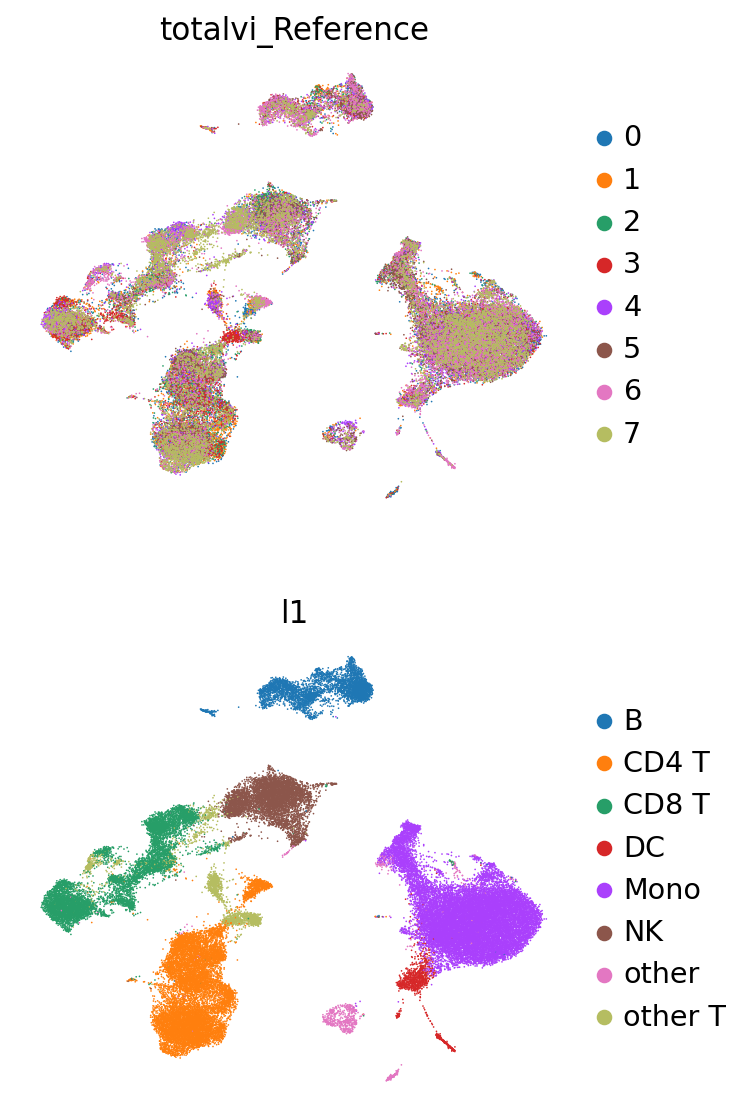

In [14]:
adata_ref = rna.copy()
sca.models.TOTALVI.setup_anndata(
    adata_ref,
    batch_key="batch",
    protein_expression_obsm_key="protein_expression"
)
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
)
vae_ref = sca.models.TOTALVI(  
    adata_ref, 
    n_latent=32,
    **arches_params
)
vae_ref.train()

adata_ref.obsm["X_totalVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_totalVI")
sc.tl.umap(adata_ref, min_dist=0.4)

sc.pl.umap(
    adata_ref,
    color=["batch","l1"],
    frameon=False,
    ncols=1,
    title="totalvi_Reference"
)
dir_path = "./results/wnn/totalvi/offline/"
vae_ref.save(dir_path, overwrite=True)

In [15]:
import os
if not os.path.exists('./comparison/results/wnn/totalvi/offline'):
    os.makedirs('./comparison/results/wnn/totalvi/offline/figures')

dir_path = '../comparison/results/wnn/totalvi/offline/'

In [16]:
pd.DataFrame(adata_ref.obsm["X_totalVI"],index=rna.obs_names).to_csv(dir_path + 'totalvi_offline_embeddings.csv')

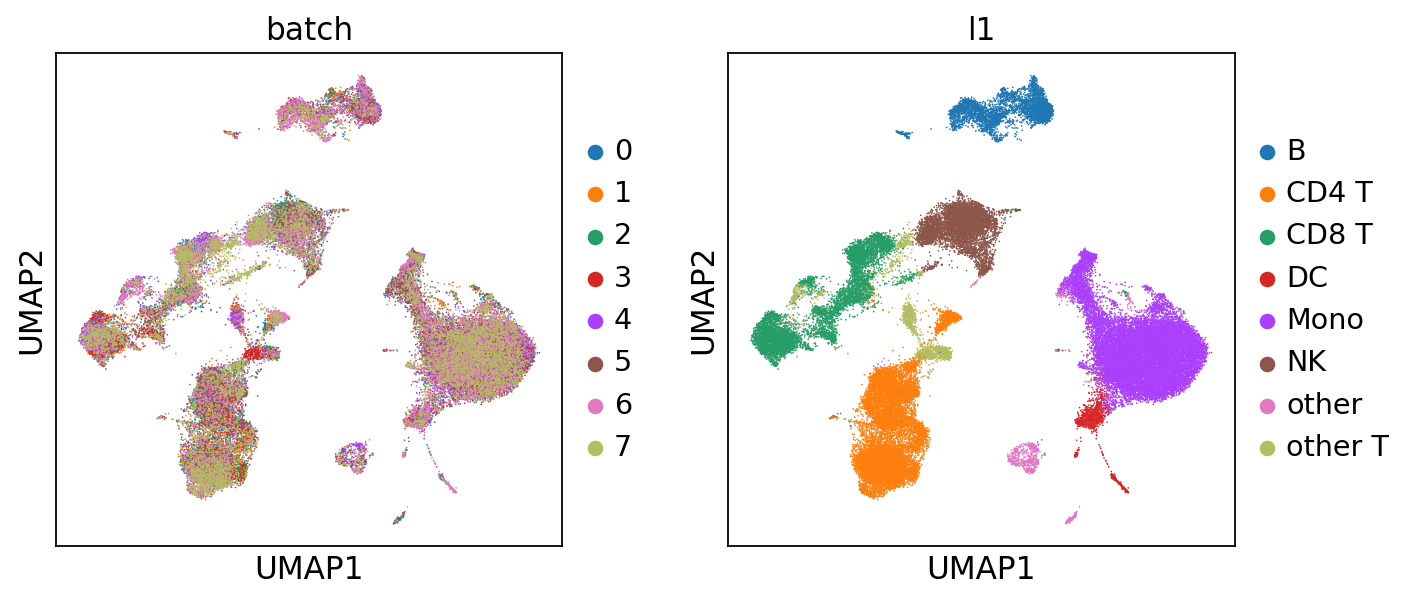

In [17]:
f = sc.pl.umap(
    adata_ref,
    color=["batch","l1"],
    show=False
)
plt.savefig('./comparison/results/wnn/figures/wnn_totalvi_offline.png')
plt.savefig('./comparison/results/wnn/totalvi/offline/figures/wnn_totalvi_offline.png')
